In [2]:
!pip install awswrangler -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 4.6.2 which is incompatible.
awscli 1.22.22 requires botocore==1.23.22, but you have botocore 1.29.142 which is incompatible.
awscli 1.22.22 requires s3transfer<0.6.0,>=0.5.0, but you have s3transfer 0.6.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import awswrangler as wr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import json

In [4]:
# pd.set_option('display.max.colwidth',80)

## Load Data

In [5]:
# monitor_hist = wr.s3.read_parquet('s3://dd-ai-ml/preprocessing/monitoring_history_202304241141.parquet')
# monitor_hist = pd.json_normalize(monitor_hist.data.apply(json.loads))
monitor_hist = wr.s3.read_csv('s3://dd-ai-ml/raw_data/preprocessing/parse_data.csv')

In [6]:
## 형변환
monitor_hist['event_date'] = pd.to_datetime(monitor_hist['event_date'])
monitor_hist['event_date_min'] = pd.to_datetime(monitor_hist['event_date_min'])
monitor_hist['crops_start_date'] = pd.to_datetime(monitor_hist['crops_start_date'])
monitor_hist['crops_end_date'] = pd.to_datetime(monitor_hist['crops_end_date'])

## 컬럼명 변경
monitor_hist.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(monitor_hist)]

In [7]:
## Test Model
monitor_hist = monitor_hist[:10000]

In [8]:
monitor_hist.shape

(10000, 59)

In [9]:
monitor_hist['event_date'].min(), monitor_hist['event_date'].max()

(Timestamp('2021-01-01 00:00:07.813000'),
 Timestamp('2021-01-07 22:56:12.813000'))

In [10]:
# ## 변수 추가생성
# monitor_hist['hour'] = monitor_hist['event_date'].dt.hour
# monitor_hist['month'] = monitor_hist['event_date'].dt.month

## 단일값 제거
for col in list(monitor_hist):
    if monitor_hist[col].nunique() <= 1:
        print(col)
        monitor_hist.drop(col, axis = 1, inplace = True)        

# ## 불필요 컬럼 제거
# rm_col = ['crops_start_date', 'crops_end_date', 'event_date']
# monitor_hist = monitor_hist[[col for col in list(monitor_hist) if col not in rm_col]]

gsm_key
green_house_id
prd_code
crops_start_date
crops_end_date
top_window_1_auto_manual_mode
top_window_2_auto_manual_mode
side_window_1_auto_manual_mode
side_window_2
side_window_2_run_status
side_window_2_auto_manual_mode
dc_power_1
dc_power_1_run_status
dc_power_1_auto_manual_mode
ac_power_1
ac_power_1_run_status
ac_power_1_auto_manual_mode
heat_cover_1_auto_manual_mode
heat_cover_2
heat_cover_2_run_status
heat_cover_2_auto_manual_mode
float_fan_1_auto_manual_mode
exhaust_fan_1_auto_manual_mode


## Test

In [11]:
## col_n = 10, MSE = 400
target_base = ['sensor_inner_temperature1_1', 'sensor_inner_hum1_1', 'sensor_plantation_temperature_1_1',
          'sensor_plantation_hum_1_1', 'sensor_inner_co2_1', 'sensor_inner_temperature1_2',
          'sensor_inner_hum1_2', 'sensor_plantation_temperature_1_2', 'sensor_plantation_hum_1_2', 'sensor_inner_co2_2',]

### col_n = 5, MSE = 200
# target_base = ['sensor_inner_temperature1_1', 'sensor_inner_hum1_1', 'sensor_plantation_temperature_1_1',
#           'sensor_plantation_hum_1_1', 'sensor_inner_co2_1']

### col_n = 1, MSE = 2
# target_base = ['sensor_inner_temperature1_1']

target = [col+'_target' for col in target_base]
target

['sensor_inner_temperature1_1_target',
 'sensor_inner_hum1_1_target',
 'sensor_plantation_temperature_1_1_target',
 'sensor_plantation_hum_1_1_target',
 'sensor_inner_co2_1_target',
 'sensor_inner_temperature1_2_target',
 'sensor_inner_hum1_2_target',
 'sensor_plantation_temperature_1_2_target',
 'sensor_plantation_hum_1_2_target',
 'sensor_inner_co2_2_target']

In [12]:
train_df = monitor_hist[:int(len(monitor_hist) * 0.8)]
train_df[target] = train_df[target_base].shift(30)
train_df.reset_index(drop = True, inplace = True)
train_df.dropna(axis = 0, inplace = True)

test_df = monitor_hist[int(len(monitor_hist) * 0.8):]
test_df[target] = test_df[target_base].shift(30)
test_df.reset_index(drop = True, inplace = True)
test_df.dropna(axis = 0, inplace = True)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-12-3c4641653af7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(axis = 0, inplace = True)
/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [13]:
train_x = train_df[[col for col in list(train_df) if col not in target]]
train_x = train_x.select_dtypes(include = ['int64', 'float64'])
train_y = train_df[[col for col in list(train_df) if col in target]]

test_x = test_df[[col for col in list(test_df) if col not in target]]
test_x = test_x.select_dtypes(include = ['int64', 'float64'])
test_y = test_df[[col for col in list(test_df) if col in target]]

In [14]:
train_x.shape, train_y.shape

((7970, 34), (7970, 10))

In [15]:
test_x.shape, test_y.shape

((1970, 34), (1970, 10))

In [16]:
# from sklearn.preprocessing import MinMaxScaler

# scl_model_x = MinMaxScaler()
# scl_model_x.fit(train_x)

# train_x = scl_model_x.transform(train_x)
# test_x = scl_model_x.transform(test_x)

# scl_model_y = MinMaxScaler()
# scl_model_y.fit(train_y)

# train_y = scl_model_y.transform(train_y)
# test_y = scl_model_y.transform(test_y)

In [18]:
import gc

gc.collect()

23

In [18]:
## y값 scaling
## 마지막 layer activation function 조정

In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Conv1D, Input, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K

tf.random.set_seed(1004)
K.clear_session()

model = Sequential([
    Input(shape = (train_x.shape[1:])),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(train_y.shape[1])
    # Dense(train_y.shape[1], activation = 'sigmoid')
])

# early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta = 0.00001)
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                90        
Total params: 1,874
Trainable params: 1,874
Non-trainable params: 0
_________________________________________________________________


In [21]:
# model.fit(train_x, train_y, epochs=30, batch_size = 64, verbose = 1, callbacks = early_stopping)
hist = model.fit(train_x, train_y, epochs=500, batch_size = 16, verbose = 1)

Epoch 1/500
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2023-05-25 01:14:05.235 tensorflow-2-6-gpu--ml-g4dn-xlarge-7eba0e151157af0bd8a25c896f03:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-25 01:14:05.261 tensorflow-2-6-gpu--ml-g4dn-xlarge-7eba0e151157af0bd8a25c896f03:18 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
499/499 [==============================] - 2s 2ms/step - loss: 8582792192.0000 - mae: 17093.7754 - mse: 8582792192.0000
Epoch 2/500
499/499 [==============================] - 1s 2ms/step - loss: 282557.5312 - mae: 216.8061 - mse: 282557.5312
Epoch 3/500
499/499 [==============================] - 1

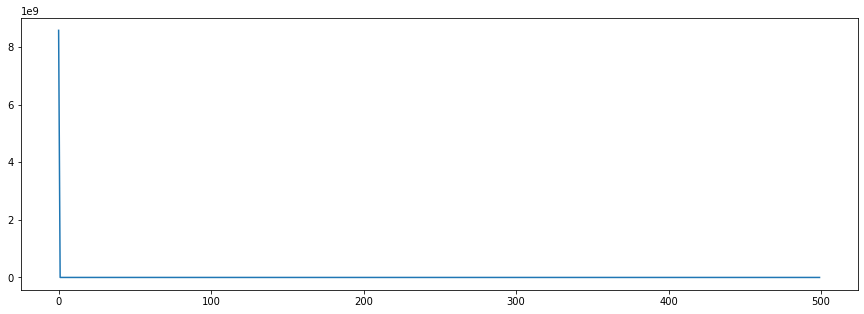

In [51]:
plt.figure(figsize = (15,5))
plt.plot(hist.history['loss'][:])
plt.show()

In [44]:
pred = model.predict(test_x)
# pred = scl_model_y.inverse_transform(pred)
# actual = scl_model_y.inverse_transform(test_y)
actual = test_y

In [45]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [46]:
mean_squared_error(actual, pred)

21514.589300548683

In [47]:
np.sqrt(mean_squared_error(actual, pred))

146.67852365138083

In [48]:
actual_df = pd.DataFrame(columns = list(target), data = actual)
pred_df = pd.DataFrame(columns = list(target), data = pred)

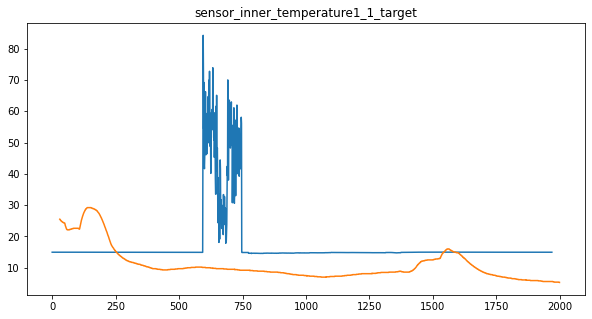

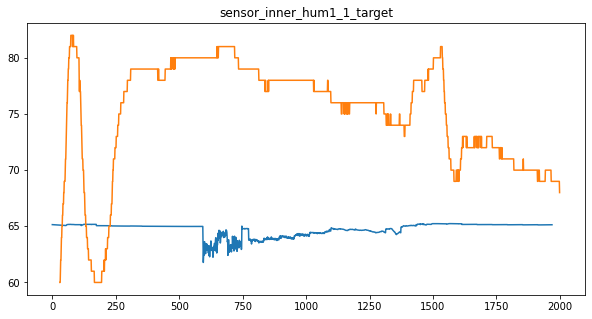

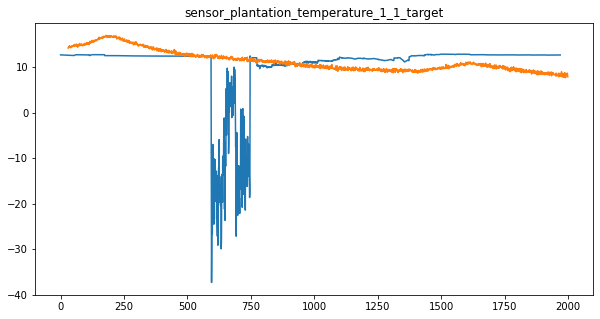

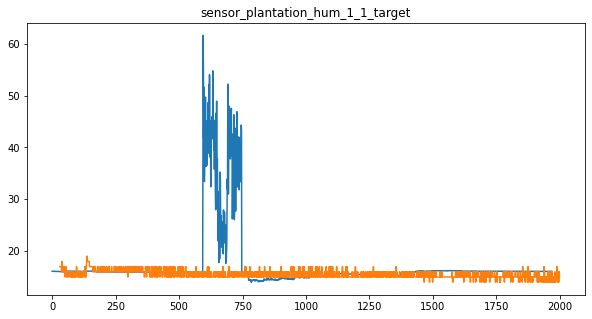

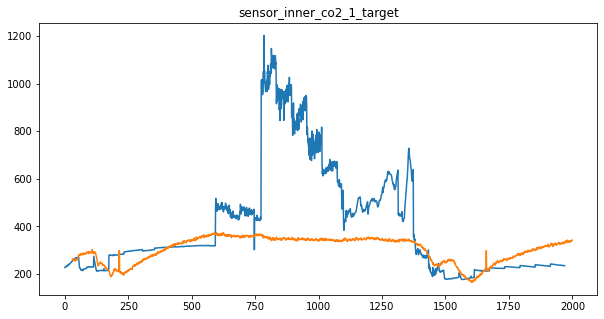

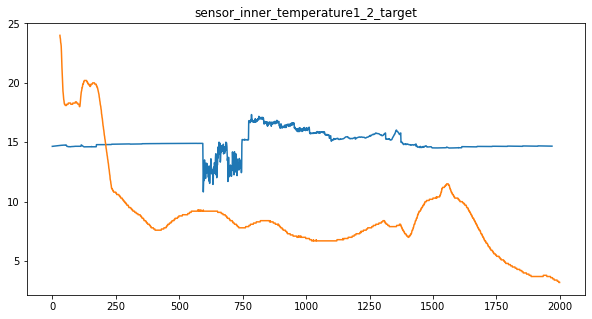

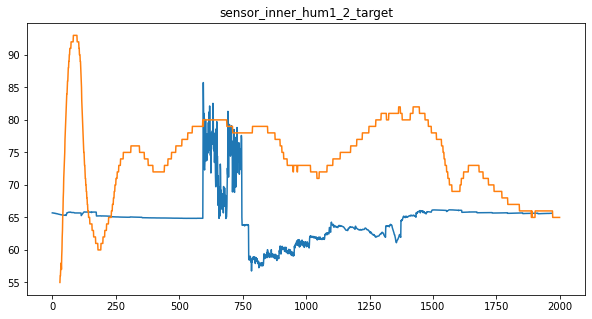

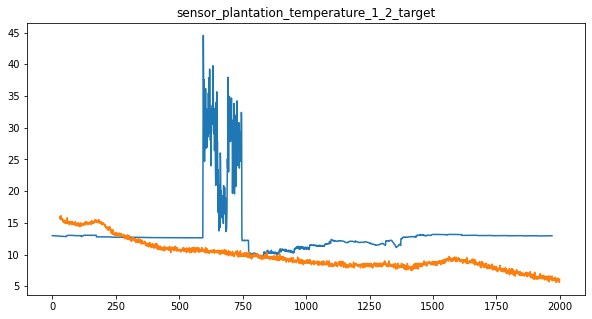

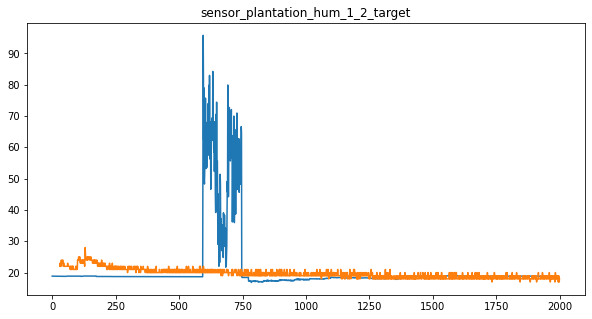

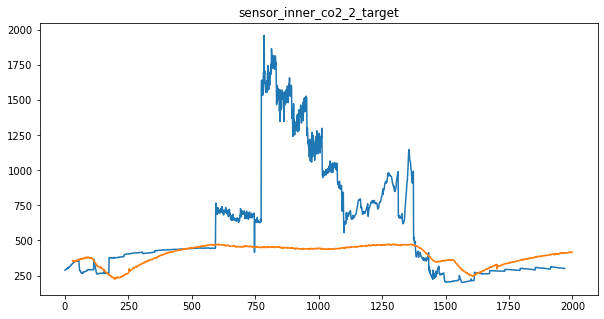

In [49]:
import matplotlib.pyplot as plt

for col in list(pred_df):
    # col = 'sensor_inner_temperature1_1_target'
    # idx = 1000000

    plt.figure(figsize = (10,5))
    plt.plot(pred_df[col][:])
    plt.plot(actual_df[col][:])
    plt.title(col)
    plt.show()